In [358]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
from sklearn.metrics import r2_score

In [359]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data.csv", sep=",")

In [360]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
0,1/31/2008,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
1,2/29/2008,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
2,3/31/2008,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,...,0.0,NaN,0.0,NaN,2.6,0.000,NaN,5.25,0.000000,NaN
3,4/30/2008,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,...,0.0,NaN,0.0,NaN,2.7,0.033,NaN,5.31,0.020000,NaN
4,5/31/2008,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,...,0.0,NaN,0.0,NaN,2.8,0.067,NaN,5.50,0.083333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,-0.100000,-0.050000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,0.000000,-0.050000
210,7/31/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.00,-0.066667,-0.083333
211,8/31/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,4.0,0.000,0.000000,4.00,-0.066667,-0.083333


In [361]:
ex_future=df[df['Ap'].isna()][['Mnd',
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
        'Rodt_skandale_lag6',
        'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
        #'Frp_reg_lag6','SV_reg_lag6', 
        #'SP_reg_lag6','KrF_reg_lag6',
        #'Venstre_reg_lag6', 
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']]

In [362]:
ex_future
ex_future["Mnd"] = pd.to_datetime(df["Mnd"])
ex_future.set_index("Mnd", inplace=True)

In [363]:
df.dropna(inplace=True)

In [364]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
5,6/30/2008,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
6,7/31/2008,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
7,8/31/2008,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
8,9/30/2008,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
9,10/31/2008,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2/28/2025,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,...,0.0,0.0,0.0,0.0,4.1,0.000,0.016667,4.50,0.000000,0.000000
206,3/31/2025,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,...,0.0,0.0,0.0,0.0,4.0,-0.033,0.000000,4.50,0.000000,0.000000
207,4/30/2025,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.20,-0.100000,-0.050000
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,-0.100000,-0.050000


In [365]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [366]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [367]:
df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,0.0,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,3.2,...,0.0,0.0,0.0,0.0,4.1,0.000,0.016667,4.50,0.000000,0.000000
2025-03-31,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4,...,0.0,0.0,0.0,0.0,4.0,-0.033,0.000000,4.50,0.000000,0.000000
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.20,-0.100000,-0.050000


In [368]:
df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df_en = df_en.diff().dropna()  # Difference to make stationary
df_orig=df

In [369]:
df_ex=df[[
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
       #'Venstre_skandale_lag6', 
        #'MDG_skandale_lag6', 
        'Rodt_skandale_lag6',
       #'Andre_skandale_lag6', 
       # 'Ap_reg', 'Hoyre_reg', 'Frp_reg', 'SV_reg',
       #'SP_reg', 'KrF_reg', 'Venstre_reg', 'MDG_reg', 'Rodt_reg', 'Andre_reg',
       #'Ap_reg_lag3', 
       'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
       # 'Frp_reg_lag6','SV_reg_lag6', 
       # 'SP_reg_lag6','KrF_reg_lag6',
       # 'Venstre_reg_lag6', 
        #'MDG_reg_lag6',
        #'Rodt_reg_lag6', 
        #'Andre_reg_lag6',
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']].iloc[1:]

In [370]:
df_ex

,Ap_skandale_lag6,Hoyre_skandale_lag6,Frp_skandale_lag6,SV_skandale_lag6,SP_skandale_lag6,KrF_skandale_lag6,Rodt_skandale_lag6,Ap_reg_lag6,Hoyre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,
2008-07-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
2008-11-30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.000,0.033333,4.75,-0.333333,-0.131667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.1,0.000,0.016667,4.50,0.000000,0.000000
2025-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,0.000000,4.50,0.000000,0.000000
2025-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,-0.016667,4.20,-0.100000,-0.050000


In [371]:
model = VAR(endog=df_en, exog=df_ex)
#model = VAR(df_en)
model_fitted = model.fit(maxlags=3,method = 'ols', trend='n', verbose=True)

print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Jul, 2025
Time:                     13:16:27
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -5.25452
Nobs:                     201.000    HQIC:                  -9.65746
Log likelihood:          -1130.74    FPE:                3.46486e-06
AIC:                     -12.6500    Det(Omega_mle):     4.59510e-07
--------------------------------------------------------------------
Results for equation Ap
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
Ap_skandale_lag6            -0.131211         0.243437           -0.539           0.590
Hoyre_skandale_lag6          0.017071         0.255591            0.067           0.947
Frp_skandale_lag6            0.0992

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [372]:
# Compute R² for each party
r2_scores = {}
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']:
    r2_scores[party] = r2_score(df_en[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.2460
R² for Hoyre: 0.3200
R² for Frp: 0.2882
R² for SV: 0.3579
R² for SP: 0.2529
R² for KrF: 0.4421
R² for Venstre: 0.3258
R² for MDG: 0.2737
R² for Rodt: 0.3599
R² for Andre: 0.3327


In [373]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [374]:
all_fitted= model_fitted.fittedvalues

In [375]:
all_fitted

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-10-31,0.178926,0.196003,-0.401223,0.547270,-0.178177,0.176733,-0.048137,0.006879,-0.271093,-0.198775
2008-11-30,0.971678,0.015769,-0.447439,-0.018002,-0.559415,0.472985,0.082821,-0.202689,-0.313304,-0.070406
2008-12-31,0.406407,0.987185,-0.076188,-0.233861,-0.135443,-0.493308,-0.310290,-0.040965,-0.287565,-0.292065
2009-01-31,2.513640,-1.633597,-0.939199,-0.235410,0.030266,-0.036880,0.207342,-0.006410,-0.047838,-0.100597
2009-02-28,1.086141,-0.693217,-0.446306,-0.292486,-0.073310,-0.062948,0.484571,0.113787,0.055031,-0.096674
...,...,...,...,...,...,...,...,...,...,...
2025-02-28,1.135814,-1.335386,-0.025708,-0.011154,0.707772,-0.023570,0.307770,-0.385718,0.058599,-0.363240
2025-03-31,1.587468,-0.711806,-0.652392,-0.165356,-0.661334,0.327653,0.344402,-0.000386,-0.198961,0.209743
2025-04-30,-0.507411,0.417190,-0.708059,-0.322529,0.407235,0.378253,0.088000,0.243921,0.046418,0.096567


In [376]:
steps = 3  # Number of steps to forecast
alpha = 0.50

forecast, lower, upper = model_fitted.forecast_interval(df_en.values[-model_fitted.k_ar:],  exog_future=ex_future, steps=steps, alpha=alpha)


In [377]:
forecast

array([[ 0.72844017, -0.36505565,  0.65044996, -0.44615259, -0.23763736,
        -0.08307172, -0.20521059,  0.19817281, -0.57771073,  0.14795502],
       [ 0.94290146,  0.30903488, -1.21478123, -0.01218983,  0.21556582,
         0.24856839,  0.12083416, -0.09335372, -0.3265122 , -0.37482346],
       [ 1.04735802, -0.68903002,  0.59827737, -0.40618917,  0.21270544,
        -0.15960515,  0.03448155, -0.04893107, -0.27690141, -0.26181497]])

In [378]:
forecast_dates = pd.date_range(start="2025-07-30", periods=steps, freq='ME')

last_actual_value = df_orig.iloc[-1]  # Last known actual data point

forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en.columns)
forecast_lower_df=pd.DataFrame(lower, index=forecast_dates, columns=df_en.columns)
forecast_upper_df=pd.DataFrame(upper, index=forecast_dates, columns=df_en.columns)

forecast_df = forecast_df.cumsum() + last_actual_value
forecast_lower_df = forecast_lower_df.cumsum() + last_actual_value
forecast_upper_df = forecast_upper_df.cumsum() + last_actual_value

In [379]:
# Get forecast covariance in differenced scale
forecast_cov = model_fitted.forecast_cov(steps=steps)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov[t] = np.sum(forecast_cov[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_df = {t: pd.DataFrame(forecast_cov[t], index=df_en.columns, columns=df_en.columns)
                            for t in range(steps)}

In [380]:
df_en=df_orig

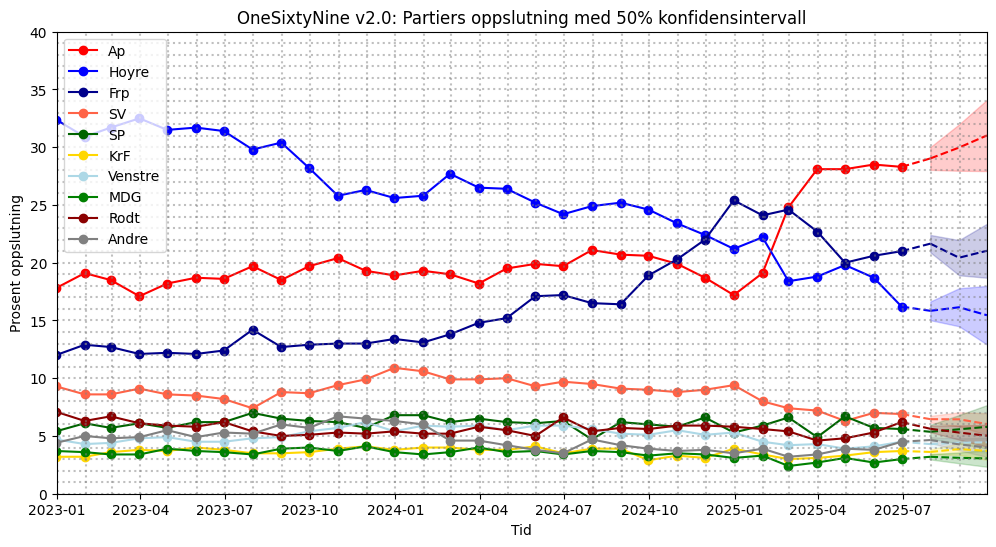

In [381]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df_en.index, df_en[party], marker="o", color=color, label=f"{party}")

    # Plot forecast 
    plt.plot(forecast_df.index, forecast_df[party], linestyle="dashed", color=color)

    last_actual_date = df_en.index[-1]
    first_forecast_date = forecast_df.index[0]
    last_actual_value = df_en[party].iloc[-1]
    first_forecast_value = forecast_df[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_df.index, 
                     forecast_lower_df[party], 
                     forecast_upper_df[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS") 
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2023-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v2.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [382]:
forecast_df=forecast_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_lower_df=forecast_lower_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_upper_df=forecast_upper_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]

In [383]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_df.loc[date_to_extract]
lower_row = forecast_lower_df.loc[date_to_extract]
upper_row = forecast_upper_df.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
print(result_df)

     Party   Estimate      Lower      Upper
0       Ap  31.018700  27.936165  34.101235
1    Hoyre  15.454949  12.918918  17.990981
2      Frp  21.033946  18.699171  23.368721
3       SV   6.035468   5.097400   6.973536
4       SP   5.790634   3.911296   7.669972
5      KrF   3.705892   2.933969   4.477814
6  Venstre   4.450105   3.550390   5.349820
7      MDG   3.055888   2.334348   3.777428
8     Rodt   5.018876   4.073153   5.964598
9    Andre   4.011317   3.195620   4.827013


In [384]:
# Multivariate MC!
n_sim = 1000000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = forecast_original_scale["Estimate"].values  # Mean estimates for all parties
cov_matrix = forecast_cov[-1]  # Covariance matrix at final step (latest forecast)

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.8524


In [385]:
sampled_df.drop(columns=["Andre"], inplace=True)

In [386]:
sample_mandate=pd.DataFrame(columns=sampled_df.columns)

In [387]:
def calc_mandat(oppslutt):
    if oppslutt <4.0:
        mandat=np.round(1/4*oppslutt**2,0)
    else: 
        oppslutt=round(1.8119*oppslutt,0)
    return int(oppslutt)

In [388]:
for party in sampled_df.columns:
    sample_mandate[party]=sampled_df[party].apply(calc_mandat)

In [389]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
0,52,30,41,12,9,3,3,3,9
1,50,34,41,9,15,3,3,2,8
2,48,36,34,13,14,3,9,3,8
3,47,28,39,13,12,3,9,3,9
4,56,26,46,10,10,3,3,3,3
...,...,...,...,...,...,...,...,...,...
999995,51,27,35,16,14,2,8,3,11
999996,50,31,36,10,18,7,9,3,8
999997,62,27,38,10,7,9,9,2,8
999998,64,19,38,11,13,3,8,3,9


In [390]:
sample_mandate['Sum']=sample_mandate.sum(axis=1)

In [391]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
0,52,30,41,12,9,3,3,3,9,162
1,50,34,41,9,15,3,3,2,8,165
2,48,36,34,13,14,3,9,3,8,168
3,47,28,39,13,12,3,9,3,9,163
4,56,26,46,10,10,3,3,3,3,160
...,...,...,...,...,...,...,...,...,...,...
999995,51,27,35,16,14,2,8,3,11,167
999996,50,31,36,10,18,7,9,3,8,172
999997,62,27,38,10,7,9,9,2,8,172
999998,64,19,38,11,13,3,8,3,9,168


In [392]:
sample_169=sample_mandate[sample_mandate["Sum"]==169].copy()

In [393]:
sample_169

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
14,61,22,39,12,7,8,8,3,9,169
25,59,27,37,11,11,8,3,3,10,169
60,53,32,36,12,12,3,9,2,10,169
91,55,29,37,10,15,2,9,2,10,169
92,56,36,35,9,12,2,9,2,8,169
...,...,...,...,...,...,...,...,...,...,...
999901,54,26,41,11,7,8,8,3,11,169
999936,64,22,35,9,12,2,8,3,14,169
999938,62,22,45,10,8,3,8,2,9,169
999939,56,28,39,10,13,2,8,2,11,169


In [394]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)
sample_169['ap_sp'] = sample_169[["Ap", "SP"]].sum(axis=1)
sample_169['ap_sp_sv'] = sample_169[["Ap", "SP", "SV"]].sum(axis=1)
sample_169['ap_sp_sv_r'] = sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)
sample_169['ap_sp_sv_r_mdg'] = sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)
sample_169['h_frp'] = sample_169[["Hoyre", "Frp"]].sum(axis=1)
sample_169['h_frp_v_krf'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)
sample_169['h_frp_v_krf_mdg'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF", "MDG"]].sum(axis=1)

In [395]:
sample_169['red_green_victory'] = sample_169['red_green'] >= 85
sample_169['ap_sp_victory'] = sample_169['ap_sp'] >= 85
sample_169['ap_sp_sv_victory'] = sample_169['ap_sp_sv'] >= 85
sample_169['ap_sp_sv_r'] = sample_169['ap_sp_sv_r'] >= 85
sample_169['ap_sp_sv_r_mdg'] = sample_169['ap_sp_sv_r_mdg'] >= 85
sample_169['h_frp'] = sample_169['h_frp'] >= 85
sample_169['h_frp_v_krf'] = sample_169['h_frp_v_krf'] >= 85
sample_169['h_frp_v_krf_mdg'] = sample_169['h_frp_v_krf_mdg'] >= 85

In [396]:
print(sample_169['red_green_victory'].mean())
print(sample_169['ap_sp_victory'].mean())
print(sample_169['ap_sp_sv_victory'].mean())
print(sample_169['ap_sp_sv_r'].mean())
print(sample_169['ap_sp_sv_r_mdg'].mean())
print(sample_169['h_frp'].mean())
print(sample_169['h_frp_v_krf'].mean())
print(sample_169['h_frp_v_krf_mdg'].mean())

0.8230090208680165
0.0011518061094119014
0.11519028998412636
0.6705834527081962
0.8230090208680165
0.00031940841689573736
0.17699097913198342
0.3294165472918038


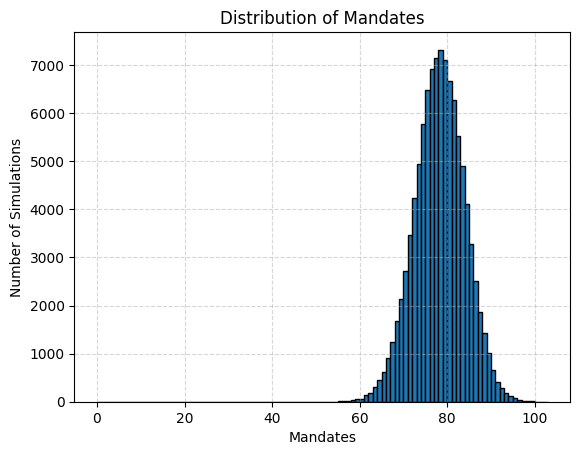

In [397]:
import matplotlib.pyplot as plt

plt.hist(sample_169['ap_sp_sv'], bins=range(0, sample_169['ap_sp_sv'].max() + 2), edgecolor='black')
plt.title('Distribution of Mandates')
plt.xlabel('Mandates')
plt.ylabel('Number of Simulations')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()